In [18]:
import numpy as np
import gillespy2
from gillespy2 import Model, Species, Reaction, Parameter, RateRule, AssignmentRule, FunctionDefinition
from gillespy2 import EventAssignment, EventTrigger, Event

from sciope.utilities.priors.uniform_prior import UniformPrior
from sciope.utilities.summarystats.identity import Identity

import matplotlib.pyplot as plt

# To run a simulation using the SSA Solver simply omit the solver argument from model.run().
from gillespy2 import VariableSSACSolver
# from gillespy2 import TauLeapingSolver
# from gillespy2 import TauHybridSolver
# from gillespy2 import ODESolver

import sciope

import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [19]:
class lotka_volterra(Model):
    def __init__(self, parameter_values=None):
        Model.__init__(self, name="lotka_volterra")
        self.volume = 1

        # Parameters
        self.add_parameter(Parameter(name="k1", expression=1.0))
        self.add_parameter(Parameter(name="k2", expression=0.005))
        self.add_parameter(Parameter(name="k3", expression=1.0))

        # Species
        self.add_species(Species(name='prey', initial_value = 100, mode = 'discrete'))
        self.add_species(Species(name='predator', initial_value = 100, mode = 'discrete'))
        
        # Reactions
        self.add_reaction(Reaction(name="r1", reactants = {'prey' : 1}, products = {'prey' : 2}, rate = self.listOfParameters['k1']))
        self.add_reaction(Reaction(name="r2", reactants = {'predator' : 1, 'prey' : 1}, products = {'predator' : 2}, rate = self.listOfParameters['k2']))
        self.add_reaction(Reaction(name="r3", reactants = {'predator' : 1}, products = {}, rate = self.listOfParameters['k3']))

        # Timespan
        self.timespan(np.linspace(0, 50, 51))
        
model = lotka_volterra()
compiled_solver = VariableSSACSolver(model)

# Data

In [20]:
#target_ts = np.load('target_ts.npy')
obs_data = np.load('target_original_shape_ts.npy')

# Prior Distributions

In [5]:
theta_true = [0,-5.8,0]

In [21]:
parameter_names = ['k1', 'k2', 'k3']
a0, b0 = np.log(0.002), np.log(2)
lower_bounds_wide = [a0, a0, a0]
upper_bounds_wide = [b0, b0, b0]
prior_wide = UniformPrior(np.array(lower_bounds_wide), np.array(upper_bounds_wide))

# Simulator

In [22]:
# Here we use the GillesPy2 Solver
from dask import delayed, compute

def simulator(params, model, transform = True):    
    res = model.run(
            solver = compiled_solver,
            show_labels = True, # remove this
            seed = np.random.randint(1e8), # remove this
            timeout = 3,
            variables = {parameter_names[i] : np.exp(params[i]) for i in range(len(parameter_names))})
    
    if res.rc == 33:
        return np.inf * np.ones((1,2,51))
    
    
    if transform:
        # Extract only observed species
        prey = res['prey']
        predator = res['predator']

        return np.vstack([prey, predator])[np.newaxis,:,:]
    else:
        return res

# Wrapper, simulator function to abc should should only take one argument (the parameter point)
def simulator2(x, transform = True):
    return simulator(x, model=model, transform = transform)

# Summary Statistics and Distance Function

### Identity Statistic and Euclidean Distance

In [23]:
from sciope.utilities.summarystats.identity import Identity
from sciope.utilities.distancefunctions.euclidean import EuclideanDistance

normalization_values = np.max(obs_data, axis = 2)[0,:]
def max_normalization(data, norm_val=normalization_values):
    dc = data[0].reshape(1,2,51).copy().astype(np.float32)
    dc_ = np.array(dc, copy=True)
    dc_[:,0,:] = dc[:,0,:]/norm_val[0]
    dc_[:,1,:] = dc[:,1,:]/norm_val[1]
    return dc_

summary_stat = Identity(max_normalization)
distance_func = EuclideanDistance()

# Inference

### Using ABC-SMC

In [24]:
from sciope.inference.smc_abc import SMCABC
from sciope.utilities.perturbationkernels.multivariate_normal import MultivariateNormalKernel
from sciope.utilities.epsilonselectors.relative_epsilon_selector import RelativeEpsilonSelector

dim = prior.get_dimension()
pk = MultivariateNormalKernel(
                d=dim,
                adapt=False, cov=0.05 * np.eye(dim))

maximum_number_of_rounds = 8
eps_selector = RelativeEpsilonSelector(20, maximum_number_of_rounds)

smcabc = SMCABC(obs_data, # Observed Dataset
          simulator2, # Simulator method
          prior_wide, # Prior
          summaries_function=summary_stat.compute,
          perturbation_kernel = pk,
          use_logger = False
          )

In [25]:
import time

np.random.seed(0)
max_gen = 5
smc_abc_gen = []
time_ticks = []
res_gen = []
for i in range(max_gen):
    time_begin = time.time()
    smc_abc_results = smcabc.infer(num_samples = 1000, batch_size = 1000, chunk_size=1, eps_selector=eps_selector)
    time_ticks.append(time.time() - time_begin)

    res_gen.append(smc_abc_results)
    posterior = np.vstack(smc_abc_results[-1]['accepted_samples'])
    gen_post = np.array([x['accepted_samples'] for x in smc_abc_results])
    smc_abc_gen.append(gen_post)
np.save('smcabc_posterior_5gen.npy',smc_abc_gen)
np.save('smcabc_posterior_5gen_time.npy',time_ticks)
np.save('smcabc_posterior_5gen_res.npy',res_gen)

Determining initial population using 20


/usr/local/lib/python3.7/site-packages/sciope/inference/abc_inference.py:119: RuntimeWarning: invalid value encountered in true_divide
  normalized_distances[:, j] = normalized_distances[:, j] / divisor[j]


Starting epsilon = 2.9329127311706547
Starting epsilon = 2.911489486694336
Starting epsilon = 2.890888500213623
Starting epsilon = 2.787575197219849
Starting epsilon = 2.615323305130005
Starting epsilon = 2.403919887542725
Starting epsilon = 2.018083429336548
Determining initial population using 20
Starting epsilon = 2.9381387710571287
Starting epsilon = 2.910369873046875
Starting epsilon = 2.8893043518066404
Starting epsilon = 2.7795478820800783
Starting epsilon = 2.590945243835449
Starting epsilon = 2.3518935203552247
Starting epsilon = 1.9491343259811402
Determining initial population using 20
Starting epsilon = 2.936702537536621
Starting epsilon = 2.91145076751709
Starting epsilon = 2.888095951080322
Starting epsilon = 2.7503366470336914
Starting epsilon = 2.590497589111328
Starting epsilon = 2.3146426677703857
Starting epsilon = 1.936496949195862
Determining initial population using 20
Starting epsilon = 2.9324296474456784
Starting epsilon = 2.906027412414551
Starting epsilon = 2.

/usr/local/lib/python3.7/site-packages/gillespy2/core/results.py:133: UserWarning: Results is of type list. Use results[i]['model'] instead of results['model'] 
  warnings.warn("Results is of type list. Use results[i]['model'] instead of results['model'] ")
/usr/local/lib/python3.7/site-packages/gillespy2/core/results.py:143: UserWarning: Results is of type list. Use results[i]['model'] instead of results['model'] 
  warnings.warn("Results is of type list. Use results[i]['model'] instead of results['model'] ")


Starting epsilon = 2.4149022102355957
Starting epsilon = 2.0327707290649415


/home/psingh/.local/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


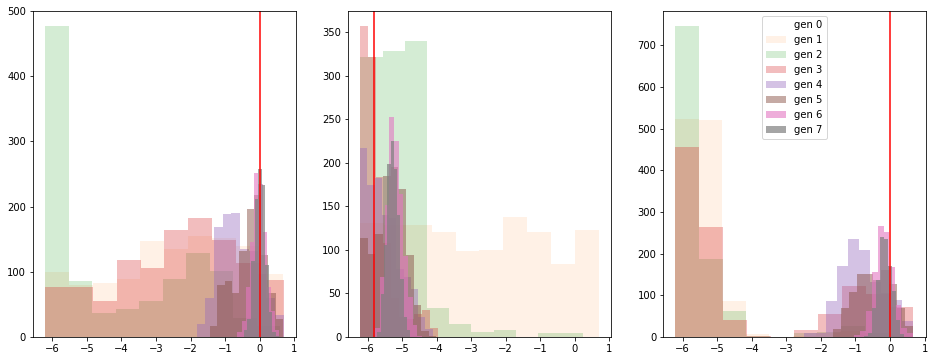

In [29]:
plt.figure(figsize=[16,6])
for j in range(len(smc_abc_results)):
    posterior = np.vstack(smc_abc_results[j]['accepted_samples'])
    for i in range(posterior.shape[1]):
        plt.subplot(1,3,i+1)
        plt.hist(posterior[:,i], alpha=0.1*j, label=f'gen {j}')
        if j == len(smc_abc_results)-1:
            plt.axvline(theta_true[i], color='red')
plt.legend()

## Analysis

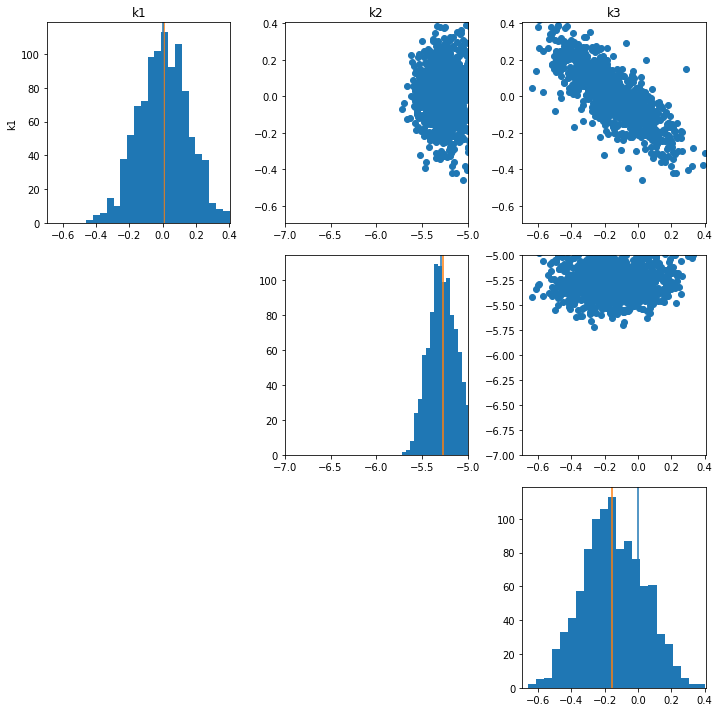

In [30]:
true_params = [1.0, 0.005, 1.0]
fig, ax = plt.subplots(posterior.shape[1], posterior.shape[1], facecolor = 'w')
for i in range(posterior.shape[1]):
    for j in range(posterior.shape[1]):
        if i > j:
            ax[i,j].axis('off')
        else:
            if i == j:
                ax[i,j].hist(posterior[:,i], bins = 'auto')
                ax[i,j].axvline(np.median(posterior[:,i]), color = 'C1')
                ax[i,j].axvline(np.log(true_params[i]))
                ax[i,j].set_xlim(lower_bounds[i], upper_bounds[i])
            else:
                ax[i,j].scatter(posterior[:,j], posterior[:,i])
                ax[i,j].set_ylim(lower_bounds[i], upper_bounds[i])
                ax[i,j].set_xlim(lower_bounds[j], upper_bounds[j])
    ax[i,0].set_ylabel(parameter_names[i])
    ax[0,i].set_title(parameter_names[i])
fig.set_size_inches(10,10)
fig.tight_layout()

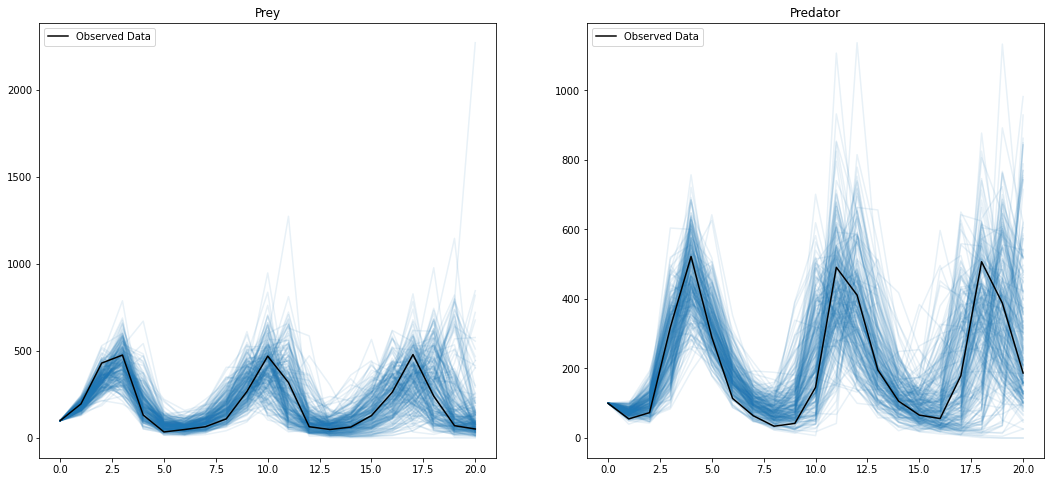

In [132]:
fig, ax = plt.subplots(1,2, facecolor = 'w', edgecolor = 'w')
for i in range(posterior.shape[0]):
    res = simulator2(posterior[i,:])
    ax[0].plot(res[0,0,:], color = 'C0', alpha = 0.1)
    ax[1].plot(res[0,1,:], color = 'C0', alpha = 0.1)
ax[0].plot(obs_data[0,0,:], color = 'black', label = 'Observed Data')
ax[1].plot(obs_data[0,1,:], color = 'black', label = 'Observed Data')
ax[0].set_title("Prey")
ax[1].set_title("Predator")
ax[0].legend()
ax[1].legend()
fig.set_size_inches(18, 8)